In [31]:
import pandas as pd
import numpy as np
from langdetect import detect
from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200

# Load Data
hotel_reviews = pd.read_csv(r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\tripadvisor\1_Waterfront-Cebu-City-Hotel-Casino.csv")

# Data Cleaning
hotel_reviews.dropna(subset=['Review Text', 'Rating'], inplace=True)
hotel_reviews['Rating'] = hotel_reviews['Rating'].apply(lambda x: float(re.findall("\d+\.\d+|\d+", x)[0]))
hotel_reviews = hotel_reviews[hotel_reviews['Review Text'].apply(lambda x: detect(x) == 'en')]
hotel_reviews['Review Text'] = hotel_reviews['Review Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

# Normalize Ratings
scaler = MinMaxScaler(feature_range=(0, 1))
hotel_reviews['Rating'] = scaler.fit_transform(hotel_reviews[['Rating']])

# Text Preprocessing
stop_words = set(stopwords.words('english'))
hotel_reviews['Review Text'] = hotel_reviews['Review Text'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words and word.isalpha()]))

# Tokenization and Padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(hotel_reviews['Review Text'])
sequences = tokenizer.texts_to_sequences(hotel_reviews['Review Text'])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Splitting Dataset
labels = hotel_reviews['Rating'].values
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)


<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
C:\Users\andyb\AppData\Local\Temp\ipykernel_16708\1180017756.py:24: SyntaxWarning: invalid escape sequence '\d'
  hotel_reviews['Rating'] = hotel_reviews['Rating'].apply(lambda x: float(re.findall("\d+\.\d+|\d+", x)[0]))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\andyb\AppData\Local\Temp\ipykernel_16708\1180017756.py:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  hotel_reviews['Review Text'] = hotel_reviews['Review Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


# General Sentimetn Analysis

Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.3180 - loss: 0.6203 - val_accuracy: 0.3261 - val_loss: 0.5210
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3883 - loss: 0.4681 - val_accuracy: 0.3315 - val_loss: 0.5108
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4074 - loss: 0.4095 - val_accuracy: 0.3315 - val_loss: 0.4968
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4190 - loss: 0.3814 - val_accuracy: 0.3315 - val_loss: 0.5049
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4273 - loss: 0.3652 - val_accuracy: 0.3261 - val_loss: 0.5126
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3936 - loss: 0.3806 - val_accuracy: 0.3261 - val_loss: 0.5072
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3967 - loss: 0.3720 - val_accuracy: 0.3207 - val_loss: 0.5126
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4124 - loss: 0.3587 - val_accuracy: 0.3261 - val_loss: 0.

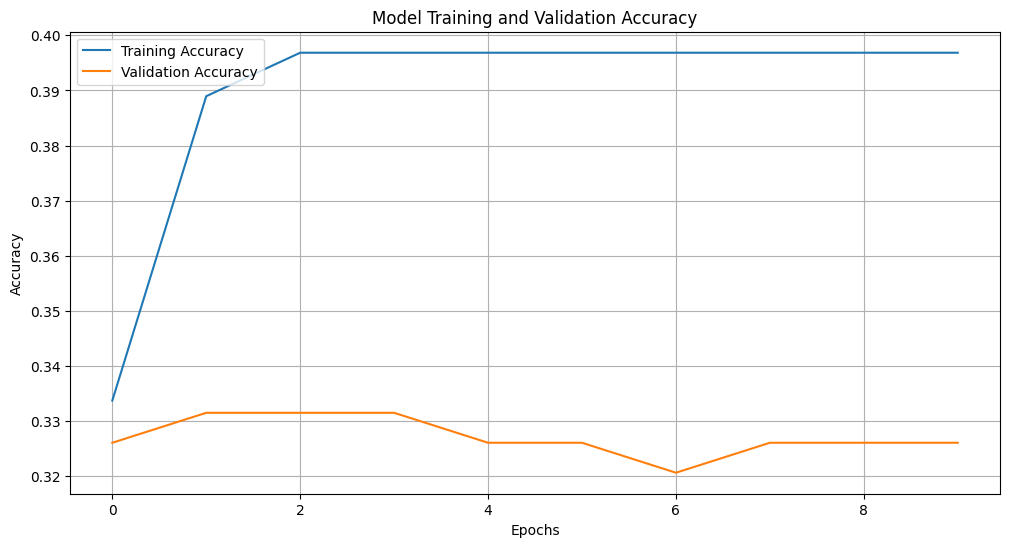

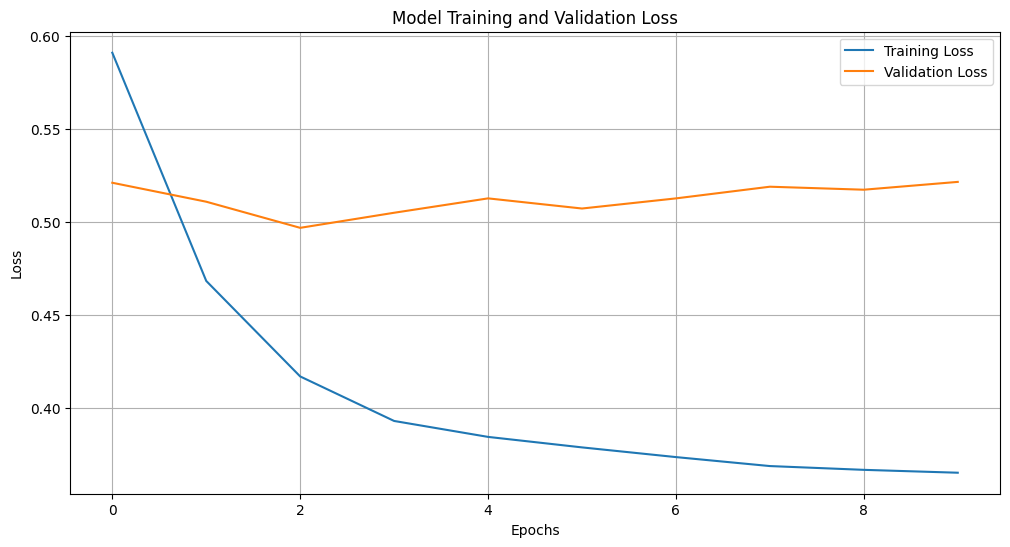

In [32]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Define CNN-biLSTM model for general sentiment analysis
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
conv1d = Conv1D(128, 5, activation='relu')(embedding)
maxpool = MaxPooling1D(2)(conv1d)
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
dropout = Dropout(0.5)(bi_lstm)
flat = Flatten()(dropout)
output = Dense(1, activation='sigmoid')(flat)
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training the CNN-biLSTM model...")
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Aspect-based Sentiment Analysis

Index(['Opinion', 'Labels'], dtype='object')
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.1428 - loss: 4.8350 - val_accuracy: 0.0993 - val_loss: 5.5104
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.1615 - loss: 5.7488 - val_accuracy: 0.0993 - val_loss: 5.9404
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2658 - loss: 6.1107 - val_accuracy: 0.0993 - val_loss: 6.3140
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.2544 - loss: 6.4709 - val_accuracy: 0.0993 - val_loss: 6.6640
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.2141 - loss: 6.9553 - val_accuracy: 0.2285 - val_loss: 7.0709
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.2940 - loss: 7.3066 - val_accuracy: 0.0993 - val_loss: 7.4467
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.1855 - loss: 7.5366 - val_accuracy: 0.4785 - val_loss: 7.7728
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.2432 - loss: 8.0050 - val_accurac

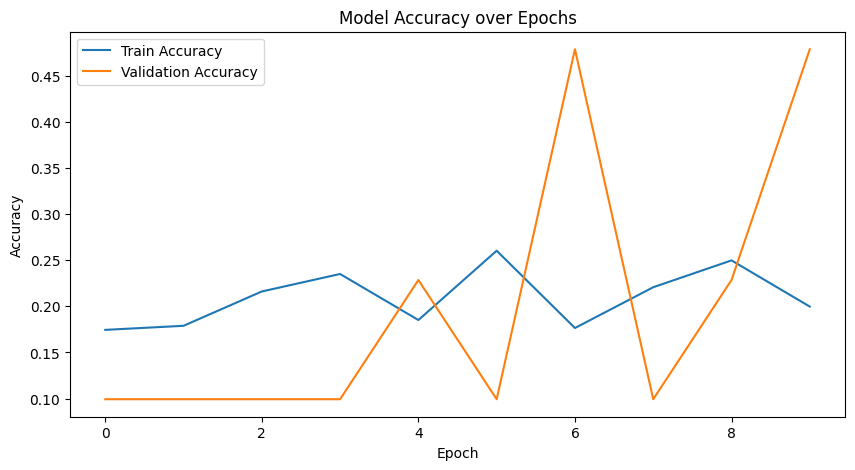

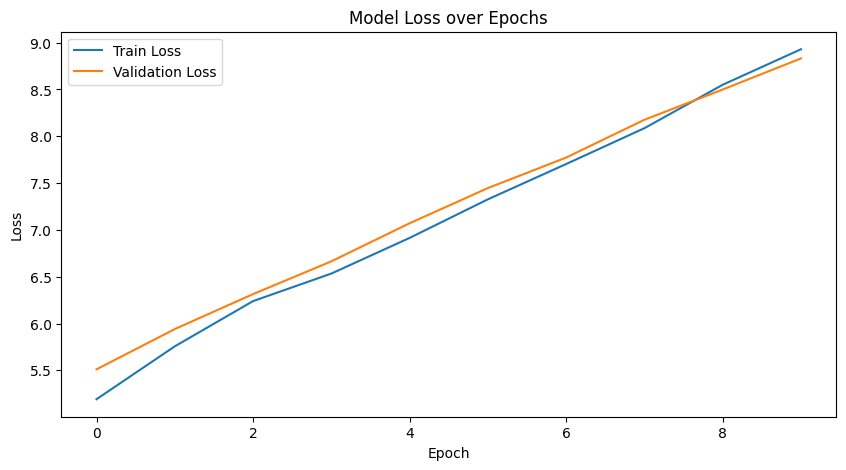

In [33]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200

# Load Aspect-Based Dataset from multiple CSV files
aspect_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv"
all_files = glob.glob(aspect_path)

# Initial empty DataFrame
aspect_data = pd.DataFrame()

# Load and unify all CSV files
for file in all_files:
    df = pd.read_csv(file)
    # Rename columns if necessary or handle missing 'Labels' column
    if 'Labels' not in df.columns:
        # Example: Assuming the column might be named 'Classification' instead
        if 'Classification' in df.columns:
            df.rename(columns={'Classification': 'Labels'}, inplace=True)
        else:
            df['Labels'] = None  # or df['Labels'] = 'default_value' if appropriate
    aspect_data = pd.concat([aspect_data, df], ignore_index=True)

# Check if 'Labels' column is properly set up
print(aspect_data.columns)

# Prepare Aspect Data
mlb = MultiLabelBinarizer()
aspect_data['Labels'] = aspect_data['Labels'].fillna('')  # Handle None or missing labels
aspect_data['Labels'] = aspect_data['Labels'].apply(lambda x: x.split(':'))
labels = mlb.fit_transform(aspect_data['Labels'])

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(aspect_data['Opinion'])  # Assuming 'Opinion' column holds the text
sequences = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Split the aspect data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_padded, labels, test_size=0.3, random_state=42)

# Define biLSTM model for Aspect-Based Analysis
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
output_aspect = Dense(len(mlb.classes_), activation='softmax')(bi_lstm_aspect)
aspect_model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile and train aspect model
print("Training the Aspect-Based Analysis model...")
aspect_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aspect_history = aspect_model.fit(x_train_aspects, y_train_aspects, epochs=10, batch_size=32, validation_split=0.1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['accuracy'], label='Train Accuracy')
plt.plot(aspect_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['loss'], label='Train Loss')
plt.plot(aspect_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


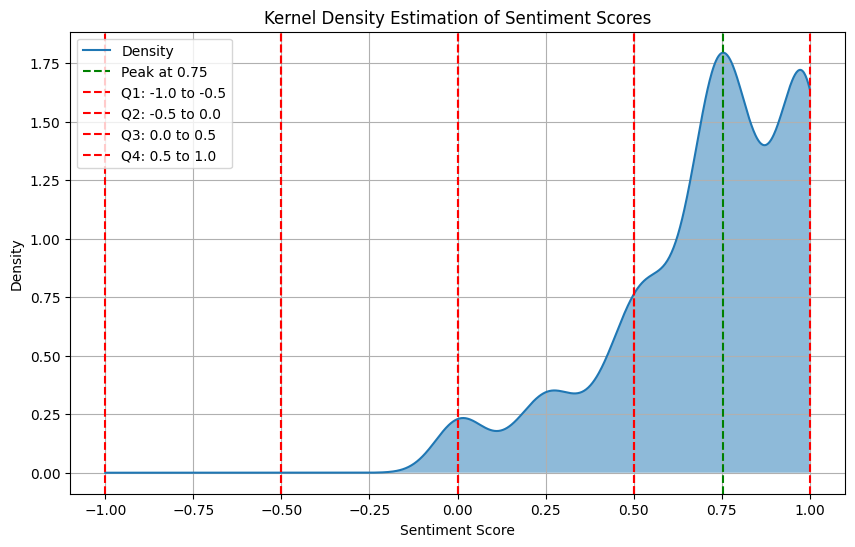

Peak value: 0.75
Quartiles: [(-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0)]


In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Model

y_pred = model.predict(x_test).flatten()  

# Define a function to plot KDE, identify peak, and fixed quartiles
def plot_kde_and_statistics(predictions, title="Sentiment Analysis Distribution"):
    plt.figure(figsize=(10, 6))
    kde = gaussian_kde(predictions)
    scores = np.linspace(-1, 1, 1000)  # fixed range for sentiment scores
    density = kde(scores)
    plt.plot(scores, density, label='Density')
    plt.fill_between(scores, density, alpha=0.5)

    # Identify peak
    peak = scores[np.argmax(density)]
    plt.axvline(x=peak, color='green', linestyle='--', label=f'Peak at {peak:.2f}')

    # Define fixed quartile ranges
    quartile_ranges = {
        'Q1': (-1.0, -0.5),
        'Q2': (-0.5, 0.0),
        'Q3': (0.0, 0.5),
        'Q4': (0.5, 1.0)
    }

    # Plot quartile ranges
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} to {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Peak value: {peak:.2f}")
    print(f"Quartiles: {list(quartile_ranges.values())}")

# Call the function to plot KDE and statistics
plot_kde_and_statistics(y_pred, title="Kernel Density Estimation of Sentiment Scores")

In [36]:
import pandas as pd
import os

# Assuming 'aspect_predictions' is your predictions from the model
# and 'mlb.classes_' contains the class labels

# Predicting aspects using the trained model
aspect_predictions = aspect_model.predict(x_test)

# Convert aspect predictions to percentage likelihoods
aspect_likelihoods = np.mean(aspect_predictions, axis=0) * 100  # Average predictions and convert to percentage

# Map percentage likelihoods to corresponding labels
aspect_percentages = {label: percent for label, percent in zip(mlb.classes_, aspect_likelihoods)}
print("Aspect percentages:", aspect_percentages)

# Create a DataFrame to hold the labels and their corresponding percentage likelihoods
aspect_percentages_df = pd.DataFrame({
    'Aspect': mlb.classes_,
    'Percentage Likelihood': aspect_likelihoods
})

# Sort the DataFrame by likelihood in descending order for better readability
aspect_percentages_df = aspect_percentages_df.sort_values(by='Percentage Likelihood', ascending=False)

# # Specify the path where you want to save the CSV
# output_dir = '/datasets/aspect-based-results/'
# output_filename = 'waterfront_aspect_percentages.csv'

# # Check if the directory exists, if not, create it
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Build the complete file path
# file_path = os.path.join(output_dir, output_filename)

# # Save the DataFrame to a CSV file
# aspect_percentages_df.to_csv(file_path, index=False)

# Print the DataFrame
aspect_percentages_df


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Aspect percentages: {'': 0.0, 'Cleanliness': 2.8522038e-10, 'Comfort & Facilities': 31.013193, 'Food': 29.330421, 'Internet': 0.0, 'Location': 9.466534, 'Staff': 30.181858, 'Value for money': 0.008161416}


,Aspect,Percentage Likelihood
2,Comfort & Facilities,3.101319e+01
6,Staff,3.018186e+01
3,Food,2.933042e+01
5,Location,9.466534e+00
7,Value for money,8.161416e-03
1,Cleanliness,2.852204e-10
0,,0.000000e+00
4,Internet,0.000000e+00
